In [80]:
import pandas as pd
import numpy as np
import folium 
from shapely.geometry import Point
import geopandas as gpd
from cartiflette import carti_download
import matplotlib.pyplot as plt

In [81]:
# =================================================================
# 1. CHARGEMENT DES DÉPARTEMENTS ET PRÉPARATION
# =================================================================

# Chargement des départements
departements = carti_download(
    values=["France"],
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

# Filtrage France métropolitaine
departements = departements.loc[departements['INSEE_DEP'] < '970'] 
departements_proj = departements.to_crs(epsg=2154)  # Reprojection en Lambert-93

import pandas as pd
import os
import sys

# Définition du nom de fichier que nous avons créé précédemment
NOM_FICHIER_DESIRE = "df_clean.csv"
chemin_complet = os.path.join(os.getcwd(), NOM_FICHIER_DESIRE)

# --- 1. Importer le fichier CSV ---
try:
    # Lecture du fichier CSV
    # Nous utilisons 'index_col=0' car l'exportation précédente (index=True) 
    # a généralement transformé l'ancien MultiIndex (time, lat, lon) en première colonne.
    df_puy_de_dome = pd.read_csv(chemin_complet, index_col=0) 
    print(f"✅ Fichier '{NOM_FICHIER_DESIRE}' importé avec succès dans 'df_puy_de_dome'.")

except FileNotFoundError:
    print(f"❌ Erreur : Le fichier CSV est introuvable à l'emplacement : {chemin_complet}")
    print("Veuillez vous assurer que le script d'exportation a été exécuté correctement.")
    sys.exit(1)
except Exception as e:
    print(f"❌ Erreur lors de l'importation du CSV : {e}")
    sys.exit(1)

# Cr"ation du dataframe geopandas
gdf = gpd.GeoDataFrame(
    df_puy_de_dome,
    geometry=gpd.points_from_xy(df_puy_de_dome['longitude'], df_puy_de_dome['latitude']),
    crs="EPSG:4326"
)
gdf = gdf.to_crs(departements_proj.crs)

#FILTRAGE SPATIAL SUR LE PUY-DE-DÔME
departement_63 = departements_proj[departements_proj['INSEE_DEP'] == '63'].copy()

df = gpd.sjoin(
    gdf, 
    departement_63[['INSEE_DEP', 'geometry']],
    predicate="within"
)

df = df.to_crs(epsg=4326)
departement_63 = departement_63.to_crs(epsg=4326)

# CALCUL DU CENTRE POUR LA CARTE

bounds = departement_63.total_bounds  # [minx, miny, maxx, maxy]
CENTER_LON = (bounds[0] + bounds[2]) / 2
CENTER_LAT = (bounds[1] + bounds[3]) / 2


✅ Fichier 'df_clean.csv' importé avec succès dans 'df_puy_de_dome'.


In [82]:
# On va prendre l'année 2000
df.index = pd.to_datetime(df.index)
gdf_2000 = df[pd.to_datetime(df.index).year == 2000]

In [83]:
gdf_2000.index.unique()

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01', '2000-11-01', '2000-12-01'],
              dtype='datetime64[ns]', name='time', freq=None)

In [84]:
#création des variables d'entrainement
# On a que le premier jour de chaque mois, ainsi on va noter 1,2,3,4,5,6,... le temps t
months = gdf_2000.index.month.unique() # ici 

# On prends des donnée qui sont dans un intervalle mu+sigma et mu-sigma
mu = gdf_2000["skt"].mean()
sigma = gdf_2000["skt"].std()

df_inter = gdf_2000[
    (gdf_2000["skt"] >= mu - sigma) &
    (gdf_2000["skt"] <= mu + sigma)
]

In [85]:
df_inter.index.unique()

DatetimeIndex(['2000-02-01', '2000-03-01', '2000-04-01', '2000-05-01',
               '2000-06-01', '2000-07-01', '2000-09-01', '2000-10-01',
               '2000-11-01', '2000-12-01'],
              dtype='datetime64[ns]', name='time', freq=None)

In [117]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel

# Préparation des données d'entraînement
X_dates = df_inter.index.month.to_numpy().reshape(-1, 1)
X_long = df_inter['longitude'].to_numpy().reshape(-1, 1)
X_lat = df_inter['latitude'].to_numpy().reshape(-1, 1)

# normalisation 
X_long = (X_long - X_long.mean()) / X_long.std()
X_lat = (X_lat - X_lat.mean()) / X_lat.std()
X_train = np.hstack((X_dates, X_long, X_lat))

y_train = df_inter['skt'].to_numpy()

In [112]:
X_train.shape

(706, 2)

In [120]:
kernel =  Matern(length_scale=3.0, nu=1.5)
gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-4,         # ou 1e-5, 1e-4 selon le dataset
    normalize_y=True,
    n_restarts_optimizer=10
)
gp.fit(X_train, y_train)


GaussianProcessRegressor(alpha=0.0001, kernel=Matern(length_scale=3, nu=1.5),
                         n_restarts_optimizer=10, normalize_y=True)

In [121]:
# Essayons maintenant de prédire le 01/01/2000
X_date_test = gdf_2000[gdf_2000.index == '2000-01-01'].index.month.to_numpy().reshape(-1, 1)
X_long_test = gdf_2000[gdf_2000.index == '2000-01-01']['longitude'].to_numpy().reshape(-1, 1)
X_lat_test = gdf_2000[gdf_2000.index == '2000-01-01']['latitude'].to_numpy().reshape(-1, 1)

# normalisation
X_long_test = (X_long_test - X_long_test.mean()) / X_long_test.std()
X_lat_test = (X_lat_test - X_lat_test.mean()) / X_lat_test.std()


X_test = np.hstack((X_date_test, X_long_test, X_lat_test))

In [122]:
y_pred_janvier = gp.predict(X_test)
y_true_janvier = gdf_2000[gdf_2000.index == '2000-01-01']['skt'].to_numpy()

In [123]:
mse = np.mean((y_true_janvier - y_pred_janvier)**2)
print("MSE =", mse)

MSE = 25.997555926508312


In [92]:
# prédire toute l'année 2000
X_date_2000 = gdf_2000.index.month.to_numpy().reshape(-1, 1)
X_long_2000 = gdf_2000['longitude'].to_numpy().reshape(-1, 1)
X_lat_2000 = gdf_2000['latitude'].to_numpy().reshape(-1, 1)

# normalisation
X_long_2000 = (X_long_2000 - X_long_2000.mean()) / X_long_2000.std()
X_lat_2000 = (X_lat_2000 - X_lat_2000.mean()) / X_lat_2000.std()
X_test_2000 = np.hstack((X_date_2000, X_long_2000, X_lat_2000))


In [93]:
# Prédictions pour toute l'année 2000
y_pred_2000 = gp.predict(X_test_2000)
y_true_2000 = gdf_2000['skt'].to_numpy()


In [94]:
# erreur
mse = np.mean((y_true_2000 - y_pred_2000)**2)
print("MSE =", mse)

MSE = 2.791404536425627


C:\Users\loicd\AppData\Local\Temp\ipykernel_16232\168278169.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


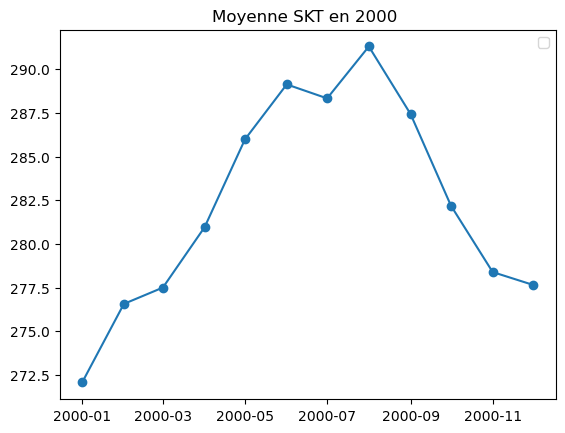

In [95]:
dates = gdf_2000.index.unique()
moy_skt_2000_true = []
for date in dates:
    val_date = gdf_2000[gdf_2000.index == date]
    moy_skt_2000_true.append(val_date["skt"].mean())

plt.plot(dates, moy_skt_2000_true,marker='o')
plt.title("Moyenne SKT en 2000 ")
plt.legend()

In [96]:
X_date_2000

array([[ 1],
       [ 1],
       [ 1],
       ...,
       [12],
       [12],
       [12]], dtype=int32)

In [97]:
dates = gdf_2000.index.unique()
skt_2000_pred = [[],[],[],[],[],[],[],[],[],[],[],[]]
moy_skt_2000_pred = []

for i in range(len(X_date_2000)):
    month_idx = X_date_2000[i][0] - 1   
    skt_2000_pred[month_idx].append(y_pred_2000[i])
    
for i in range(len(skt_2000_pred)):
    moy_skt_2000_pred.append(np.mean(skt_2000_pred[i]))

C:\Users\loicd\AppData\Local\Temp\ipykernel_16232\2274933453.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


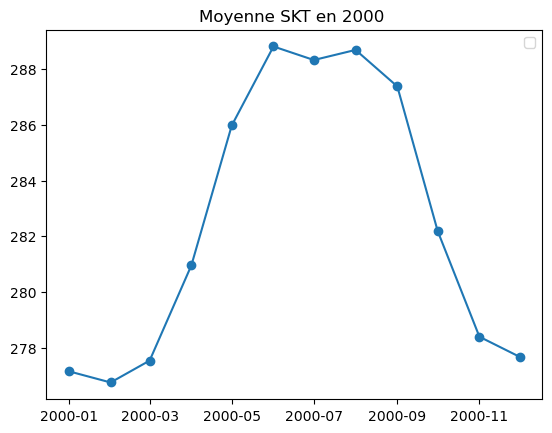

In [98]:
plt.plot(dates, moy_skt_2000_pred,marker='o')
plt.title("Moyenne SKT en 2000 ")
plt.legend()

In [107]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU,Dropout,LSTM,SimpleRNN
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
# Données
day_sin = np.sin(2 * np.pi * X_dates / 365)
day_cos = np.cos(2 * np.pi * X_dates / 365)
X_train = np.column_stack([
    day_sin,
    day_cos,
    X_long,
    X_lat
])

In [152]:
input_layer = Input(shape=(4,))  # (day_sin, day_cos, lon, lat)
output = 0
x = Dense(128, activation='relu')(input_layer)   
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)

output = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)


In [158]:
model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
)


Epoch 1/100


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 11.5806 - mae: 2.8645 - val_loss: 61.1903 - val_mae: 7.6657
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.5762 - mae: 2.8590 - val_loss: 66.3410 - val_mae: 7.9655
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.6271 - mae: 2.8973 - val_loss: 61.7298 - val_mae: 7.7048
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.6104 - mae: 2.8553 - val_loss: 60.3128 - val_mae: 7.6019
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.6087 - mae: 2.8891 - val_loss: 65.3545 - val_mae: 7.9183
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.4601 - mae: 2.8567 - val_loss: 59.7157 - val_mae: 7.5729
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.5575 - mae: 2.9092 - val_loss: 63.7808 - val_mae: 7.8306
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.4540 - mae: 2.8584 - val_loss: 60.9695 - val_mae: 7.6472
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.4005 - mae: 2.8

In [159]:
# Données

day_sin_test = np.sin(2 * np.pi * X_date_test / 365)
day_cos_test = np.cos(2 * np.pi * X_date_test / 365)
X_test = np.column_stack([
    day_sin_test,
    day_cos_test,
    X_long_test,
    X_lat_test
])

In [160]:

y_pred = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [161]:
# résultats
# erreur
mse = np.mean((y_true_2000 - y_pred)**2)
print("MSE =", mse)

MSE = 44.44505270576504


In [ ]:
#Préparation des données 